# Constructing a WIMP Spectrum

The point of this notebook is to construct what a Si low-mass WIMP spectrum would look like at very low energy, with an HVeV detector biased to ~100V in the 1-5 e/h pair region. This is to illustrate how a variance in the nuclear recoil charge production can produce large effects. 

## Get the WIMP CDF

In [1]:
#get the stored CDF from a file
import dataPython as dp
import numpy as np
#data = dp.getXYZdata('WIMP_xsections/WIMP_Si_PDF_CDF_0.5GeV_1e-06keV_steps_fmt.txt')
data = dp.getXYZdata('WIMP_xsections/WIMP_Si_PDF_CDF_1GeV_5e-05keV_steps_fmt.txt')

#convert to numpy arrays
ekev = np.asarray(data['xx'])
pdf = np.asarray(data['yy'])
cdf = np.asarray(data['zz'])

print(data.keys())

dict_keys(['xx', 'yy', 'zz'])


In [2]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

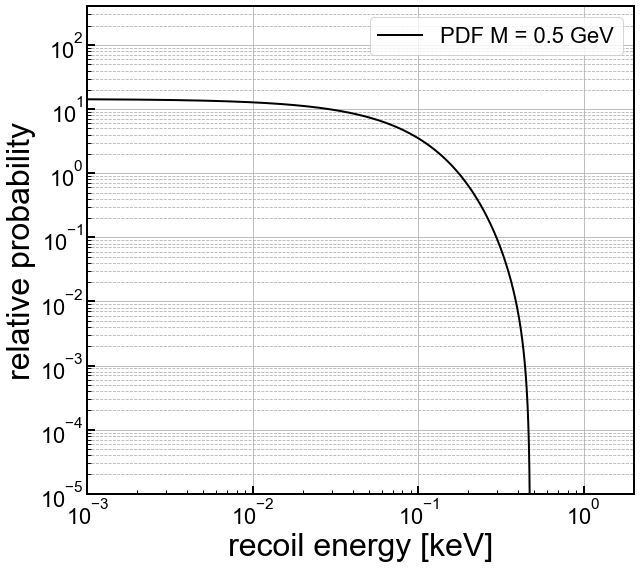

In [3]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmin = 0.001
xmax = 2
X = np.arange(xmin,xmax,0.01)

ax1.plot(ekev,pdf,'k-',label='PDF M = 0.5 GeV')


ymin=1e-5
ymax=400


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('relative probability',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

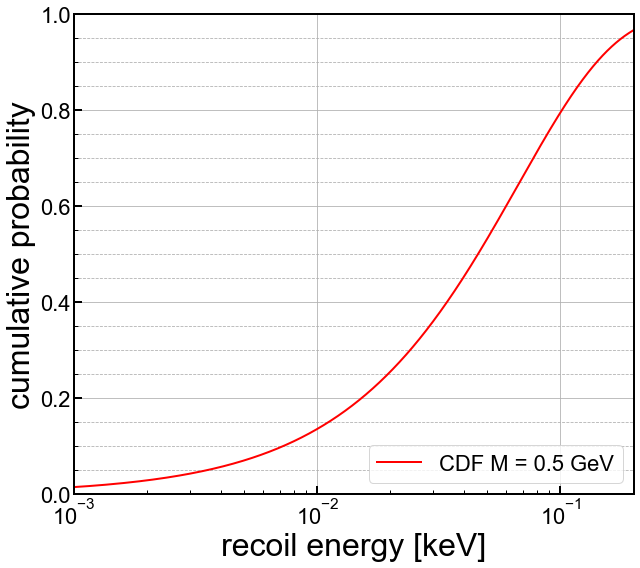

In [4]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmin = 0.001
xmax = 0.2
X = np.arange(xmin,xmax,0.01)

ax1.plot(ekev,cdf,'r-',label='CDF M = 0.5 GeV')


ymin=1e-5
ymax=1


ax1.set_yscale('linear')
ax1.set_xscale('log')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('cumulative probability',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

## Interpolate Inverted WIMP CDF and Generate Er

In [5]:
import scipy.interpolate as inter

#find first place cdf is unity
idx = np.arange(0,np.shape(cdf)[0])
print(idx)
idx_unity = idx[cdf>=1]
min_unity = np.min(idx_unity)
cdf_cut = cdf[idx<=min_unity]
ekev_cut = ekev[idx<=min_unity]

g = inter.InterpolatedUnivariateSpline (cdf_cut, ekev_cut, k=3)

[   0    1    2 ... 9997 9998 9999]


In [6]:
print(g(0.65))

0.06796898360512178


## Grab the Yield Model (DAMIC) and Generate N

In [7]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()
damic_yv = np.vectorize(damic_y) #vectorize it

In [8]:
#dream up some constants
F=1
eps = 3.8 #for silicon
V = 200

Ntot = 10000

#get a bunch of recoil energies and the average numbers
u = np.random.uniform(0,1,(Ntot,))
Er = g(u)*1000 #use eV
print(Er[0:10])
Nav = Er*damic_yv(Er)*(1/eps)
print(Nav[0:10])


#approximate a discrete normal dist by rounding
N = np.round(np.random.normal(Nav,np.sqrt(F*(Nav))))
print(np.shape(N))
print(N[0:10])
#N = np.round(np.random.normal((Nav,np.sqrt(F*(Nav)),np.shape(Nav)))) #discretize a normal distribution
#print(N[0:10])

#get the total phonon energy
Ep = N*V + Er
Ep_cal = Ep/V
print(Ep[0:10])
print(Ep_cal[0:10])



[ 64.91320322   6.90459157  64.12753741  25.46516299  74.10050602
  86.54365118 104.22437596  68.97693935  25.5532544  172.25738467]
[0.77296402 0.06917226 0.76200691 0.27076797 0.90391409 1.08947902
 1.36912007 0.83024618 0.27177859 2.61261708]
(10000,)
[ 0.  0.  1. -0. -0. -0.  3.  1.  1.  2.]
[ 64.91320322   6.90459157 264.12753741  25.46516299  74.10050602
  86.54365118 704.22437596 268.97693935 225.5532544  572.25738467]
[0.32456602 0.03452296 1.32063769 0.12732581 0.37050253 0.43271826
 3.52112188 1.3448847  1.12776627 2.86128692]


In [9]:
n,nx = np.histogram(Ep_cal,100,range=(0,5))

xc = (nx[:-1] + nx[1:]) / 2

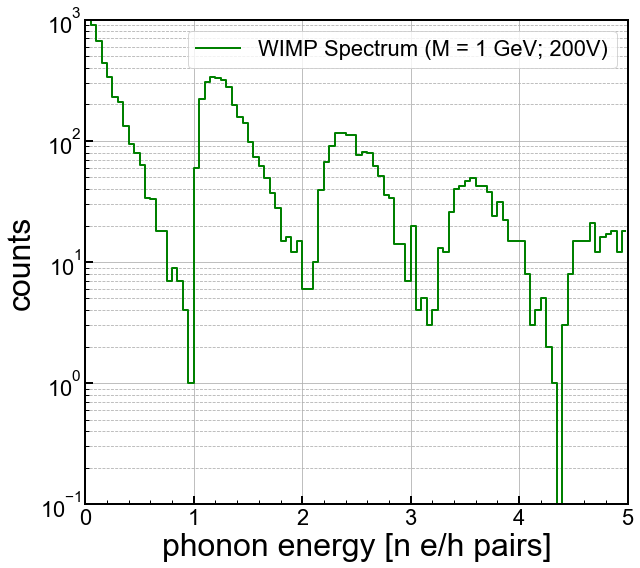

In [10]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

X = np.arange(0,5,0.01)

label1 = 'WIMP Spectrum (M = 1 GeV; {0:3d}V)'.format(V)
step, = ax1.step(xc,n, where='mid',color='g', linestyle='-', label=label1, linewidth=2)
#ax1.plot(X,gaus(X,*popt),'k-',label='fit')


ymin=0.1
ymax=1000


ax1.set_yscale('log')
ax1.set_xlim(0, 5)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('phonon energy [n e/h pairs]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/WIMPs_1GeV_HVeV.png')
plt.show()